# Classifying Songs on the Billboard Hot 100

- **True Positive**: Predict song is in the top 10, and it is in the top 10
- **False Positive**: Predict song is in the top 10, but it is not in the top 10
- **True Negative**: Predict song is not in the top 10, and it is not in the top 10
- **False Negative**: Predict song is not in the top 10, but it is in the top 10

- **High Recall**: Most top 10 songs were correctly predicted
    - No concern for number of songs that were incorrectly predicted as top 10
- **High Precision**: Among the predictions of top 10 songs, most predictions are correct
    - No concern for number of missed songs that were in top 10

In [131]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import pickle
import pandas_profiling
import patsy
from collections import defaultdict
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline
from scipy.stats import boxcox
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

# Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


In [150]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.precision', 3)

In [151]:
with open('songs_features_final_df.pkl','rb') as read_file:
    songs_features_final_df = pickle.load(read_file)

In [154]:
songs_features_final_df['Top_10_Song'].replace('Yes', 1, inplace=True)
songs_features_final_df['Top_10_Song'].replace('No', 0, inplace=True)

In [155]:
artist_list = songs_features_final_df['Performer'].value_counts()
artist_list_df = pd.DataFrame(artist_list).reset_index()
artist_list_df.columns = ['Performer', 'Performer_Count']
artist_list_df


Performer  Performer_Count
0                                       Glee Cast              161
1                                           Drake               76
2                                    Taylor Swift               65
3                                     The Beatles               59
4                                      Elton John               53
...                                           ...              ...
7172                             The Fifth Estate                1
7173                                  Trey Lorenz                1
7174                                  Passion Pit                1
7175            Santana Featuring The Product G&B                1
7176  Lisa Lisa And Cult Jam Featuring Full Force                1

[7177 rows x 2 columns]

In [156]:
song_name_list = songs_features_final_df['Song'].value_counts()
song_name_df = pd.DataFrame(song_name_list).reset_index()
song_name_df.columns = ['Song', 'Song_Name_Count']
song_name_df

Song  Song_Name_Count
0                                 You               14
1                             Hold On               14
2                               Angel               13
3                               Crazy               11
4                                Stay               11
...                               ...              ...
18134                          Mañana                1
18135                     Fly With Me                1
18136                   Walking Along                1
18137  I Wouldn't Want To Be Like You                1
18138         Scars To Your Beautiful                1

[18139 rows x 2 columns]

In [157]:
songs_features_final_df = songs_features_final_df.merge(artist_list_df, how='left', on='Performer')
songs_features_final_df = songs_features_final_df.merge(song_name_df, how='left', on='Song')
songs_features_final_df

Top_10_Song                 Song     Performer  \
0                1     Poor Little Fool  Ricky Nelson   
1                1        Splish Splash   Bobby Darin   
2                1                 When   Kalin Twins   
3                1           Yakety Yak  The Coasters   
4                1         My True Love    Jack Scott   
...            ...                  ...           ...   
21691            0               Heaven        Avicii   
21692            0       Please Tell Me        Future   
21693            0         Amor Genuino         Ozuna   
21694            0         XanaX Damage        Future   
21695            0  Government Official        Future   

                             SongID  Debut_Position Debut_Week Debut_Month  \
0      Poor Little FoolRicky Nelson               1 1958-08-02      August   
1          Splish SplashBobby Darin               3 1958-08-02      August   
2                   WhenKalin Twins               5 1958-08-02      August   
3            Yakety YakThe Coasters               7 1958-08-02      August   
4            My True LoveJack Scott               8 1958-08-02      August   
...                             ...             ...        ...         ...   
21691                  HeavenAvicii              83 2019-06-22        June   
21692          Please Tell MeFuture              87 2019-06-22        June   
21693             Amor GenuinoOzuna              92 2019-06-22        June   
21694            XanaX DamageFuture              98 2019-06-22        June   
21695     Government OfficialFuture              99 2019-06-22        June   

      Debut_Season  Debut_Year Debut_Decade  Peak_Position Week_at_Peak  \
0           Summer        1958         50's              1   1958-08-02   
1           Summer        1958         50's              3   1958-08-02   
2           Summer        1958         50's              5   1958-08-02   
3           Summer        1958         50's              7   1958-08-02   
4           Summer        1958         50's              3   1958-08-16   
...            ...         ...          ...            ...          ...   
21691       Summer        2019         10's             83   2019-06-22   
21692       Summer        2019         10's             87   2019-06-22   
21693       Summer        2019         10's             92   2019-06-22   
21694       Summer        2019         10's             98   2019-06-22   
21695       Summer        2019         10's             99   2019-06-22   

      Peak_Month Peak_Season  Peak_Year Peak_Decade  Weeks_on_Chart  \
0         August      Summer       1958        50's              11   
1         August      Summer       1958        50's               8   
2         August      Summer       1958        50's               9   
3         August      Summer       1958        50's               7   
4         August      Summer       1958        50's              14   
...          ...         ...        ...         ...             ...   
21691       June      Summer       2019        10's               1   
21692       June      Summer       2019        10's               1   
21693       June      Summer       2019        10's               1   
21694       June      Summer       2019        10's               1   
21695       June      Summer       2019        10's               1   

       Weeks_in_Top10 Time_to_Top10  Danceability  Energy Key  Loudness  \
0                11.0        0 days         0.543   0.332   C   -11.573   
1                 8.0        0 days         0.645   0.943   C    -1.526   
2                 9.0        0 days         0.646   0.582  F#   -12.679   
3                 7.0        0 days         0.715   0.669   G    -9.491   
4                14.0       14 days         0.548   0.253   E   -11.387   
...               ...           ...           ...     ...  ..       ...   
21691             0.0           NaT         0.592   0.873   A    -5.650   
21692             0.0          

In [162]:
songs_features_final_df[songs_features_final_df['Song'] == 'Redbone']

Top_10_Song     Song         Performer                   SongID  \
20550            0  Redbone  Childish Gambino  RedboneChildish Gambino   

       Debut_Position Debut_Week Debut_Month Debut_Season  Debut_Year  \
20550              75 2016-12-10    December       Winter        2016   

      Debut_Decade  Peak_Position Week_at_Peak Peak_Month Peak_Season  \
20550         10's             12   2017-08-19     August      Summer   

       Peak_Year Peak_Decade  Weeks_on_Chart  Weeks_in_Top10 Time_to_Top10  \
20550       2017        10's              44             0.0           NaT   

       Danceability  Energy Key  Loudness   Mode  Acousticness  \
20550         0.743   0.347  C#   -11.174  Major         0.167   

       Instrumentalness  Liveness  Valence    Tempo  Duration_min  \
20550              0.01     0.103    0.572  160.143         5.449   

      Time_Signature  Performer_Count  Song_Name_Count  
20550            4/4                7                1

In [138]:
songs_features_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21696 entries, 0 to 21695
Data columns (total 33 columns):
Top_10_Song         21696 non-null int64
Song                21696 non-null object
Performer           21696 non-null object
SongID              21696 non-null object
Debut_Position      21696 non-null int64
Debut_Week          21696 non-null datetime64[ns]
Debut_Month         21696 non-null object
Debut_Season        21696 non-null object
Debut_Year          21696 non-null int64
Debut_Decade        21696 non-null object
Peak_Position       21696 non-null int64
Week_at_Peak        21696 non-null datetime64[ns]
Peak_Month          21696 non-null object
Peak_Season         21696 non-null object
Peak_Year           21696 non-null int64
Peak_Decade         21696 non-null object
Weeks_on_Chart      21696 non-null int64
Weeks_in_Top10      21696 non-null float64
Time_to_Top10       4095 non-null timedelta64[ns]
Danceability        21696 non-null float64
Energy              21696 non-n

In [139]:
model_columns = ['Top_10_Song', 'Performer_Count', 'Song_Name_Count', 'Debut_Position',    \
       'Song_Name_Count', 'Performer_Count', 'Danceability',    \
       'Energy', 'Loudness', 'Acousticness', 'Instrumentalness', 'Liveness',    \
       'Valence', 'Tempo', 'Duration_min', 'Debut_Season', 'Debut_Month', "Debut_Decade",    \
       'Key', 'Mode', 'Time_Signature']
songs_features_modeling_df = songs_features_final_df.loc[:,model_columns]
songs_feat_eng_df = songs_features_modeling_df

In [140]:
# First round of transformations
songs_features_final_df['Acousticness'] = boxcox(songs_features_final_df['Acousticness'], 0.5)
songs_features_final_df['Debut_Position'] = boxcox(songs_features_final_df['Debut_Position'], 0)
songs_features_final_df['Loudness'] = songs_features_final_df['Loudness']**2
# songs_features_final_df['Instrumentalness'] = boxcox(songs_features_final_df['Instrumentalness'], 0.5)
# songs_features_final_df['Performer_Count'] = boxcox(songs_features_final_df['Performer_Count'], 0.5)
# songs_features_final_df['Song_Name_Count'] = boxcox(songs_features_final_df['Song_Name_Count'], 0.5)
# songs_features_final_df['Valence'] = boxcox(songs_features_final_df['Valence'], 0)
songs_features_final_df['Liveness'] = boxcox(abs(songs_features_final_df['Liveness']-songs_features_final_df['Liveness'].mean()), 0.5)
# songs_features_final_df['Loudness'] = math.log(songs_features_final_df['Loudness'])
songs_features_final_df['Tempo'] = boxcox(abs(songs_features_final_df['Tempo']-songs_features_final_df['Tempo'].mean()), 0.5)

# # More aggressive transformations
# songs_features_final_df['Acousticness'] = songs_features_final_df['Acousticness']**(1/3)
# songs_features_final_df['Debut_Position'] = boxcox(abs(songs_features_final_df['Debut_Position']-songs_features_final_df['Debut_Position'].mean()), 0)
# songs_features_final_df['Loudness'] = songs_features_final_df['Loudness']**2
# songs_features_final_df['Instrumentalness'] = boxcox(abs(songs_features_final_df['Instrumentalness']-songs_features_final_df['Instrumentalness'].mean()),0)
# songs_features_final_df['Performer_Count'] = songs_features_final_df['Performer_Count']
# songs_features_final_df['Song_Name_Count'] = songs_features_final_df['Song_Name_Count']
# songs_features_final_df['Valence'] = boxcox(abs(songs_features_final_df['Valence']-songs_features_final_df['Valence'].mean()), 0.5)
# songs_features_final_df['Liveness'] = boxcox(abs(songs_features_final_df['Liveness']-songs_features_final_df['Liveness'].mean()), 0)
# songs_features_final_df['Loudness'] = songs_features_final_df['Loudness']**(1/3)
# songs_features_final_df['Tempo'] = boxcox(abs(songs_features_final_df['Tempo']-songs_features_final_df['Tempo'].mean()), 0.5)


In [141]:
songs_feat_eng = songs_feat_eng_df.to_csv (r'/Users/andrewgraves/Data_Science/Metis/Bootcamp/project_3/songs_feat_eng.csv', header=True)
pd.read_csv('/Users/andrewgraves/Data_Science/Metis/Bootcamp/project_3/songs_feat_eng.csv').profile_report()


In [43]:
# sns.pairplot(songs_features_modeling_df)

In [44]:
heatmap_df = songs_features_modeling_df.iloc[:,:15].corr()
heatmap_df

Top_10_Song  Performer_Count  Song_Name_Count  \
Top_10_Song          1.000000         0.037962         0.022495   
Performer_Count      0.037962         1.000000         0.020588   
Song_Name_Count      0.022495         0.020588         1.000000   
Debut_Position      -0.292262        -0.190937        -0.033642   
Song_Name_Count      0.022495         0.020588         1.000000   
Performer_Count      0.037962         1.000000         0.020588   
Danceability         0.063180        -0.101436        -0.043459   
Energy              -0.020422        -0.048818        -0.027262   
Loudness            -0.021953         0.005218         0.004011   
Acousticness        -0.001140         0.062310         0.013959   
Instrumentalness    -0.017284        -0.054699        -0.003014   
Liveness            -0.032072         0.003734        -0.015290   
Valence              0.045052        -0.055185        -0.049737   
Tempo               -0.015747         0.002312        -0.005916   
Duration_min         0.036161        -0.030328         0.020337   

                  Debut_Position  Song_Name_Count  Performer_Count  \
Top_10_Song            -0.292262         0.022495         0.037962   
Performer_Count        -0.190937         0.020588         1.000000   
Song_Name_Count        -0.033642         1.000000         0.020588   
Debut_Position          1.000000        -0.033642        -0.190937   
Song_Name_Count        -0.033642         1.000000         0.020588   
Performer_Count        -0.190937         0.020588         1.000000   
Danceability           -0.071158        -0.043459        -0.101436   
Energy                 -0.064851        -0.027262        -0.048818   
Loudness               -0.148224         0.004011         0.005218   
Acousticness            0.116490         0.013959         0.062310   
Instrumentalness        0.059993        -0.003014        -0.054699   
Liveness                0.012744        -0.015290         0.003734   
Valence                 0.105200        -0.049737        -0.055185   
Tempo                  -0.004548        -0.005916         0.002312   
Duration_min           -0.087416         0.020337        -0.030328   

                  Danceability    Energy  Loudness  Acousticness  \
Top_10_Song           0.063180 -0.020422 -0.021953     -0.001140   
Performer_Count      -0.101436 -0.048818  0.005218      0.062310   
Song_Name_Count      -0.043459 -0.027262  0.004011      0.013959   
Debut_Position       -0.071158 -0.064851 -0.148224      0.116490   
Song_Name_Count      -0.043459 -0.027262  0.004011      0.013959   
Performer_Count      -0.101436 -0.048818  0.005218      0.062310   
Danceability          1.000000  0.200995  0.122163     -0.305145   
Energy                0.200995  1.000000  0.688227     -0.588445   
Loudness              0.122163  0.688227  1.000000     -0.409159   
Acousticness         -0.305145 -0.588445 -0.409159      1.000000   
Instrumentalness      0.003789 -0.004852 -0.134539      0.033341   
Liveness             -0.133034  0.115139  0.045263      0.036720   
Valence               0.403423  0.350058  0.017501     -0.118941   
Tempo                -0.148513  0.166060  0.096685     -0.110737   
Duration_min          0.088457  0.127299  0.045579     -0.300305   

                  Instrumentalness  Liveness   Valence     Tempo  Duration_min  
Top_10_Song              -0.017284 -0.032072  0.045052 -0.015747      0.036161  
Performer_Count          -0.054699  0.003734 -0.055185  0.002312     -0.030328  
Song_Name_Count          -0.003014 -0.015290 -0.049737 -0.005916      0.020337  
Debut_Position            0.059993  0.012744  0.105200 -0.004548     -0.087416  
Song_Name_Count          -0.003014 -0.015290 -0.049737 -0.005916      0.020337  
Performer_Count          -0.054699  0.003734 -0.055185  0.002312     -0.030328  
Danceability              0.003789 -0.133034  0.403423 -0.148513      0.088457  
Energy                   -0.004852  0.115139  0.350058  0.166060      0.127299  
Loudne

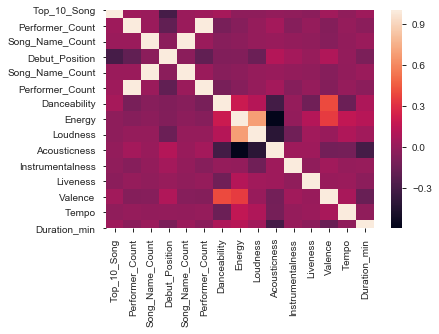

In [45]:
sns.heatmap(heatmap_df)

In [10]:
songs_features_final = songs_features_final_df.to_csv (r'/Users/andrewgraves/Data_Science/Metis/Bootcamp/project_3/songs_features_final.csv', header=True)
# pd.read_csv('/Users/andrewgraves/Data_Science/Metis/Bootcamp/project_3/songs_features_final.csv').profile_report()


In [11]:
songs_features_final_df.columns

Index(['Top_10_Song', 'Song', 'Performer', 'SongID', 'Debut_Position',
       'Debut_Week', 'Debut_Month', 'Debut_Season', 'Debut_Year',
       'Debut_Decade', 'Peak_Position', 'Week_at_Peak', 'Peak_Month',
       'Peak_Season', 'Peak_Year', 'Peak_Decade', 'Weeks_on_Chart',
       'Weeks_in_Top10', 'Time_to_Top10', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Duration_min', 'Time_Signature', 'Performer_Count',
       'Song_Name_Count'],
      dtype='object')

## Target
- Top_10_Song

## Features
- Debut_Position
- Danceability
- Energy
- Loudness
- Acousticness
- Instrumentalness
- Liveness
- Valence
- Tempo
- Duration_min
- Performer_Count
- Song_Name_Count

### Dummy Features
- Debut_Month
- Debut_Season
- Debut_Decade
- Key
- Mode
- Time_Signature

In [12]:
season = patsy.dmatrix('Debut_Season', data=songs_features_final_df,return_type='dataframe')
month = patsy.dmatrix('Debut_Month', data=songs_features_final_df,return_type='dataframe')
decade = patsy.dmatrix('Debut_Decade', data=songs_features_final_df,return_type='dataframe')
key = patsy.dmatrix('Key', data=songs_features_final_df,return_type='dataframe')
mode = patsy.dmatrix('Mode', data=songs_features_final_df,return_type='dataframe')
time_sig = patsy.dmatrix('Time_Signature', data=songs_features_final_df,return_type='dataframe')

In [13]:
songs_features_final_df = pd.merge(songs_features_final_df, season, right_index = True, left_index = True)
songs_features_final_df = pd.merge(songs_features_final_df, month, right_index = True, left_index = True)
songs_features_final_df = pd.merge(songs_features_final_df, decade, right_index = True, left_index = True)
songs_features_final_df = pd.merge(songs_features_final_df, key, right_index = True, left_index = True)
songs_features_final_df = pd.merge(songs_features_final_df, mode, right_index = True, left_index = True)
songs_features_final_df = pd.merge(songs_features_final_df, time_sig, right_index = True, left_index = True)


In [14]:
del songs_features_final_df['Intercept_x']
del songs_features_final_df['Intercept_y']

In [15]:
songs_features_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21696 entries, 0 to 21695
Data columns (total 67 columns):
Top_10_Song                 21696 non-null int64
Song                        21696 non-null object
Performer                   21696 non-null object
SongID                      21696 non-null object
Debut_Position              21696 non-null int64
Debut_Week                  21696 non-null datetime64[ns]
Debut_Month                 21696 non-null object
Debut_Season                21696 non-null object
Debut_Year                  21696 non-null int64
Debut_Decade                21696 non-null object
Peak_Position               21696 non-null int64
Week_at_Peak                21696 non-null datetime64[ns]
Peak_Month                  21696 non-null object
Peak_Season                 21696 non-null object
Peak_Year                   21696 non-null int64
Peak_Decade                 21696 non-null object
Weeks_on_Chart              21696 non-null int64
Weeks_in_Top10              216

In [16]:
songs_features_final_df.rename(columns = {'Debut_Position': 'Debut_Position',    \
                                          'Song_Name_Count': 'Song_Name_Count',    \
                                          'Performer_Count': 'Performer_Count',    \
                                          'Danceability': 'Danceability',    \
                                          'Energy': 'Energy',    \
                                          'Loudness': 'Loudness',    \
                                          'Acousticness': 'Acousticness',    \
                                          'Instrumentalness': 'Instrumentalness',    \
                                          'Liveness': 'Liveness',    \
                                          'Valence': 'Valence',    \
                                          'Tempo': 'Tempo',    \
                                          'Duration_min': 'Duration_min',    \
                                          'Debut_Season[T.Spring]': 'Debut_Season(T.Spring)',    \
                                          'Debut_Season[T.Summer]': 'Debut_Season(T.Summer)',    \
                                          'Debut_Season[T.Winter]': 'Debut_Season(T.Winter)',    \
                                          'Debut_Month[T.August]': 'Debut_Month(T.August)',    \
                                          'Debut_Month[T.December]': 'Debut_Month(T.December)',    \
                                          'Debut_Month[T.February]': 'Debut_Month(T.February)',    \
                                          'Debut_Month[T.January]': 'Debut_Month(T.January)',    \
                                          'Debut_Month[T.July]': 'Debut_Month(T.July)',    \
                                          'Debut_Month[T.June]': 'Debut_Month(T.June)',    \
                                          'Debut_Month[T.March]': 'Debut_Month(T.March)',    \
                                          'Debut_Month[T.May]': 'Debut_Month(T.May)',    \
                                          'Debut_Month[T.November]': 'Debut_Month(T.November)',    \
                                          'Debut_Month[T.October]': 'Debut_Month(T.October)',    \
                                          'Debut_Month[T.September]': 'Debut_Month(T.September)',    \
                                          "Debut_Decade[T.10's]": "Debut_Decade(T.10's)",    \
                                          "Debut_Decade[T.50's]": "Debut_Decade(T.50's)",    \
                                          "Debut_Decade[T.60's]": "Debut_Decade(T.60's)",    \
                                          "Debut_Decade[T.70's]": "Debut_Decade(T.70's)",    \
                                          "Debut_Decade[T.80's]": "Debut_Decade(T.80's)",    \
                                          "Debut_Decade[T.90's]": "Debut_Decade(T.90's)",    \
                                          'Key[T.B]': 'Key(T.B)',    \
                                          'Key[T.Bb]': 'Key(T.Bb)',    \
                                          'Key[T.C]': 'Key(T.C)',    \
                                          'Key[T.C#]': 'Key(T.C#)',    \
                                          'Key[T.D]': 'Key(T.D)',    \
                                          'Key[T.D#]': 'Key(T.D#)',    \
                                          'Key[T.E]': 'Key(T.E)',    \
                                          'Key[T.F]': 'Key(T.F)',    \
                                          'Key[T.F#]': 'Key(T.F#)',    \
                                          'Key[T.G]': 'Key(T.G)',    \
                                          'Key[T.G#]': 'Key(T.G#)',    \
                                          'Mode[T.Minor]': 'Mode(T.Minor)',    \
                                          'Time_Signature[T.4/4]': 'Time_Signature(T.4/4)',    \
                                          'Time_Signature[T.5/4]': 'Time_Signature(T.5/4)'}, inplace=True)

In [17]:
songs_features_final_df.columns

Index(['Top_10_Song', 'Song', 'Performer', 'SongID', 'Debut_Position',
       'Debut_Week', 'Debut_Month', 'Debut_Season', 'Debut_Year',
       'Debut_Decade', 'Peak_Position', 'Week_at_Peak', 'Peak_Month',
       'Peak_Season', 'Peak_Year', 'Peak_Decade', 'Weeks_on_Chart',
       'Weeks_in_Top10', 'Time_to_Top10', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Duration_min', 'Time_Signature', 'Performer_Count',
       'Song_Name_Count', 'Debut_Season(T.Spring)', 'Debut_Season(T.Summer)',
       'Debut_Season(T.Winter)', 'Debut_Month(T.August)',
       'Debut_Month(T.December)', 'Debut_Month(T.February)',
       'Debut_Month(T.January)', 'Debut_Month(T.July)', 'Debut_Month(T.June)',
       'Debut_Month(T.March)', 'Debut_Month(T.May)', 'Debut_Month(T.November)',
       'Debut_Month(T.October)', 'Debut_Month(T.September)',
       'Debut_Decade(T.10's)', 'Debut_Decade(T.50's)', 'Debut_Decade(T.60's)',

In [19]:
# with open('song_features_modeling.pkl', 'wb') as to_write:
#     pickle.dump(songs_features_final_df, to_write)

In [142]:
# # No transformations/changes to data
# X_columns = ['Debut_Position', 'Song_Name_Count', 'Performer_Count', 'Danceability',    \
#        'Energy', 'Loudness', 'Acousticness', 'Instrumentalness', 'Liveness',    \
#        'Valence', 'Tempo', 'Duration_min',    \
#        'Debut_Season[T.Spring]', 'Debut_Season[T.Summer]',    \
#        'Debut_Season[T.Winter]', 'Debut_Month[T.August]',    \
#        'Debut_Month[T.December]', 'Debut_Month[T.February]',    \
#        'Debut_Month[T.January]', 'Debut_Month[T.July]', 'Debut_Month[T.June]',    \
#        'Debut_Month[T.March]', 'Debut_Month[T.May]', 'Debut_Month[T.November]',    \
#        'Debut_Month[T.October]', 'Debut_Month[T.September]',    \
#        "Debut_Decade[T.10's]", "Debut_Decade[T.50's]", "Debut_Decade[T.60's]",    \
#        "Debut_Decade[T.70's]", "Debut_Decade[T.80's]", "Debut_Decade[T.90's]",    \
#        'Key[T.B]', 'Key[T.Bb]', 'Key[T.C]', 'Key[T.C#]', 'Key[T.D]',    \
#        'Key[T.D#]', 'Key[T.E]', 'Key[T.F]', 'Key[T.F#]', 'Key[T.G]',    \
#        'Key[T.G#]', 'Mode[T.Minor]', 'Time_Signature[T.4/4]',    \
#        'Time_Signature[T.5/4]']

In [253]:
# No transformations/changes to data

X_columns = ['Debut_Position', 'Song_Name_Count', 'Performer_Count', 'Danceability',    \
       'Energy', 'Loudness', 'Acousticness', 'Instrumentalness', 'Liveness',    \
       'Valence', 'Tempo', 'Duration_min',    \
       'Debut_Season(T.Spring)', 'Debut_Season(T.Summer)',    \
       'Debut_Season(T.Winter)', 'Debut_Month(T.August)',    \
       'Debut_Month(T.December)', 'Debut_Month(T.February)',    \
       'Debut_Month(T.January)', 'Debut_Month(T.July)', 'Debut_Month(T.June)',    \
       'Debut_Month(T.March)', 'Debut_Month(T.May)', 'Debut_Month(T.November)',    \
       'Debut_Month(T.October)', 'Debut_Month(T.September)',    \
       "Debut_Decade(T.10's)", "Debut_Decade(T.50's)", "Debut_Decade(T.60's)",    \
       "Debut_Decade(T.70's)", "Debut_Decade(T.80's)", "Debut_Decade(T.90's)",    \
       'Key(T.B)', 'Key(T.Bb)', 'Key(T.C)', 'Key(T.C#)', 'Key(T.D)',    \
       'Key(T.D#)', 'Key(T.E)', 'Key(T.F)', 'Key(T.F#)', 'Key(T.G)',    \
       'Key(T.G#)', 'Mode(T.Minor)', 'Time_Signature(T.4/4)',    \
       'Time_Signature(T.5/4)']

In [254]:
X = songs_features_final_df.loc[:, X_columns] # no transformations/changes to data

In [255]:
y = songs_features_final_df['Top_10_Song']

In [256]:
y.value_counts()

0    17601
1     4095
Name: Top_10_Song, dtype: int64

In [257]:
y.value_counts()[1]/(y.value_counts()[1]+y.value_counts()[0])

0.18874446902654868

In [258]:
# No transformations/changes to data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, stratify=y_train_val, random_state=43)

In [259]:
# Scale training and test dataframes:

std = StandardScaler()
std.fit(X_train.values)

X_tr_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)
X_te_scaled = std.transform(X_test.values)

In [260]:
# Convert arrays back to dataframes - dropped outliers, no dropped p-vals
X_tr = pd.DataFrame(X_tr_scaled, index = X_train.index, columns = X_columns)
X_v = pd.DataFrame(X_val_scaled, index = X_val.index, columns = X_columns)
X_te = pd.DataFrame(X_te_scaled, index = X_test.index, columns = X_columns)

## KNN Classification

In [151]:
accuracy_dict = {}

for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr, y_train)
    acc_score = knn.score(X_tr, y_train)
    accuracy_dict[(str(k))] = acc_score

In [152]:
for key, value in accuracy_dict.items():
    if value == max(accuracy_dict.values()):
        print('The best k value, and associated accuracy score, are:', key,'&', 100*value)

The best k value, and associated accuracy score, are: 1 & 100.0


In [153]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_tr, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_tr, y_train)))
print("Validation set: {:6.2f}%".format(100*knn.score(X_v, y_val)))

The score for kNN is
Training: 100.00%
Validation set:  71.81%


In [154]:
confuse_mtx_labels = np.array(['Yes', 'No'])
y_predict = knn.predict(X_v)

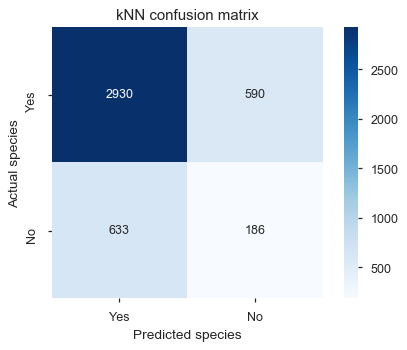

In [155]:
knn_confusion = confusion_matrix(y_val, y_predict)
plt.figure(dpi=90)
ax = sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'd',
           xticklabels=confuse_mtx_labels,
           yticklabels=confuse_mtx_labels)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('kNN confusion matrix');

# True Positive (Predict top 10 song, it is a top 10 song) = 2930
# False Positive (Predict top 10 song, it is not a top 10 song) = 633
# True Negative (Predict not a top 10 song, it is not a top 10 song) = 186
# False Negative (Predict not a top 10 song, it is a top 10 song) = 590

In [156]:
# using the default threshold of 0.5, which is what vanilla predict does
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f},    F1 Score: {:6.4}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict), f1_score(y_val, y_predict)))


Default threshold:
Precision: 0.2397,   Recall: 0.2271,    F1 Score: 0.2332


## Logistic Regression Classification

In [157]:
# l1 - sum of squares of regression weights - add penalty to that formula
# C tells you how to change coefficients

accuracy_dict_log = {}

for C in np.linspace(0.01,1,10):
    logit = LogisticRegression(C = C, solver='lbfgs')
    logit.fit(X_tr, y_train)
    acc_score2 = logit.score(X_tr, y_train)
    accuracy_dict_log[C] = acc_score2

In [158]:
for key, value in accuracy_dict_log.items():
    if value == max(accuracy_dict_log.values()):
        print('The best C value, and associated accuracy score, are:', key,'&', 100*value)

The best C value, and associated accuracy score, are: 0.12 & 82.64577091495737
The best C value, and associated accuracy score, are: 0.23 & 82.64577091495737


In [159]:
logit = LogisticRegression(C = 0.12)
logit.fit(X_tr, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_tr, y_train)))
print("Validation set: {:6.2f}%".format(100*logit.score(X_v, y_val)))

The score for logistic regression is
Training:  82.64%
Validation set:  83.06%


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


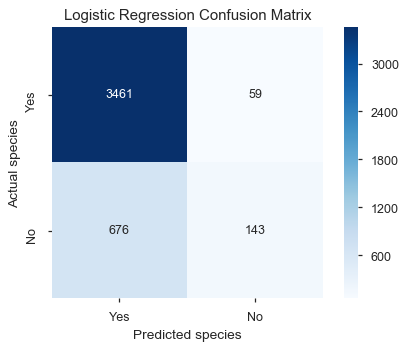

In [160]:
# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(y_val, logit.predict(X_v))
plt.figure(dpi=90)
ax = sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=confuse_mtx_labels,
           yticklabels=confuse_mtx_labels)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Logistic Regression Confusion Matrix');

# True Positive (Predict top 10 song, it is a top 10 song) = 3461
# False Positive (Predict top 10 song, it is not a top 10 song) = 676
# True Negative (Predict not a top 10 song, it is not a top 10 song) = 143
# False Negative (Predict not a top 10 song, it is a top 10 song) = 59

In [161]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = logit.predict(X_v)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f},    F1 Score: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict), f1_score(y_val, y_predict)))


Default threshold:
Precision: 0.7079,   Recall: 0.1746,    F1 Score: 0.2801


In [162]:
# beta_coefficients = list(zip(X_train.columns, lasso_model.coef_))
# beta_coefficients

## Naive Bayes

- For Naive Bayes, we will only look at the Gaussian classifier. The Bernoulli classifier assumes all features are binary, while Multinomial assumes all features are discrete (some features are negative, so this will not work).

In [163]:
nb = GaussianNB()
nb.fit(X_tr, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*nb.score(X_tr, y_train)))
print("Validation set: {:6.2f}%".format(100*nb.score(X_v, y_val)))

The score for logistic regression is
Training:  75.81%
Validation set:  76.49%


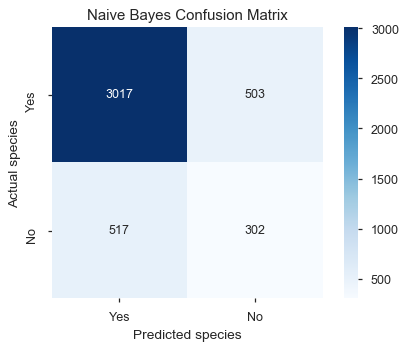

In [164]:
# Print confusion matrix for logistic regression
nb_confusion = confusion_matrix(y_val, nb.predict(X_v))
plt.figure(dpi=90)
ax = sns.heatmap(nb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=confuse_mtx_labels,
           yticklabels=confuse_mtx_labels)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Naive Bayes Confusion Matrix');

# True Positive (Predict top 10 song, it is a top 10 song) = 3017
# False Positive (Predict top 10 song, it is not a top 10 song) = 517
# True Negative (Predict not a top 10 song, it is not a top 10 song) = 302
# False Negative (Predict not a top 10 song, it is a top 10 song) = 503

In [165]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = nb.predict(X_v)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f},    F1 Score: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict), f1_score(y_val, y_predict)))


Default threshold:
Precision: 0.3752,   Recall: 0.3687,    F1 Score: 0.3719


## Pipeline for All Classifiers

- SVM
- Random Forests
- Decision tree can only subdivide into rectangular regions, while linearSVC can make any linear boundary it wants.  In other words, linearSVC is better for diagonal decision boundaries, while decision trees are better for quadrant decision boundaries

In [261]:
classifiers = [    \
    KNeighborsClassifier(n_neighbors=1),    \
    LogisticRegression(C = 0.12),    \
    GaussianNB(),    \
    LinearSVC(),    \
    SVC(gamma="auto"),    \
    SVC(kernel="poly", gamma="auto"),    \
    SVC(gamma="scale"),    \
    DecisionTreeClassifier(max_depth=4),    \
    RandomForestClassifier(n_estimators=100),    \
    MLPClassifier(activation="identity"),    \
    MLPClassifier(),    \
    XGBClassifier()]

model_list = ['KNN', 'Logistic Regression', 'Naive Bayes',    \
              'SVM (Linear)', 'SVC', 'SVC (Poly Kernel)', 'SVC (Radial Kernel)',    \
              'Decision Tree', 'Random Forests', 'Neural Network (Linear)',    \
              'Neural Network (Non-linear)',    \
              'XGBoost']
precision_list = []
recall_list = []
f1_score_list = []

for index, classifier in enumerate(classifiers):
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_tr, y_train)  
    print(classifier)
    y_predict = pipe.predict(X_v)
    precision_list.append(100*precision_score(y_val, y_predict))
    recall_list.append(100*recall_score(y_val, y_predict))
    f1_score_list.append(100*f1_score(y_val, y_predict))
    print(classification_report(y_val, y_predict))
    

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      3520
           1       0.24      0.23      0.23       819

    accuracy                           0.72      4339
   macro avg       0.53      0.53      0.53      4339
weighted avg       0.71      0.72      0.72      4339

LogisticRegression(C=0.12, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      3520
           1       0.71      0.17      0.28       8

/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      3520
           1       0.71      0.14      0.23       819

    accuracy                           0.83      4339
   macro avg       0.77      0.56      0.57      4339
weighted avg       0.81      0.83      0.78      4339

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      3520
           1       0.74      0.10      0.18       819

    accuracy                           0.82     

/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3520
           1       0.42      0.32      0.36       819

    accuracy                           0.79      4339
   macro avg       0.64      0.61      0.62      4339
weighted avg       0.77      0.79      0.78      4339

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_s

In [262]:
class_metric_dict = {'Precision': precision_list,    \
                     'Recall': recall_list, 'F1 Score': f1_score_list}
class_metric_df = pd.DataFrame(class_metric_dict, index=model_list)
class_metric_df.sort_values(by='F1 Score', ascending = False, inplace=True)
class_metric_df.round(1)

Precision  Recall  F1 Score
Decision Tree                     59.8    28.9      39.0
Naive Bayes                       37.5    36.9      37.2
Neural Network (Non-linear)       42.4    31.9      36.4
XGBoost                           77.8    21.4      33.5
Random Forests                    79.2    17.2      28.3
Logistic Regression               70.8    17.5      28.0
Neural Network (Linear)           71.5    16.2      26.5
KNN                               24.0    22.7      23.3
SVM (Linear)                      71.3    13.7      23.0
SVC (Poly Kernel)                 64.4    11.7      19.8
SVC                               73.9    10.4      18.2
SVC (Radial Kernel)               73.9    10.4      18.2

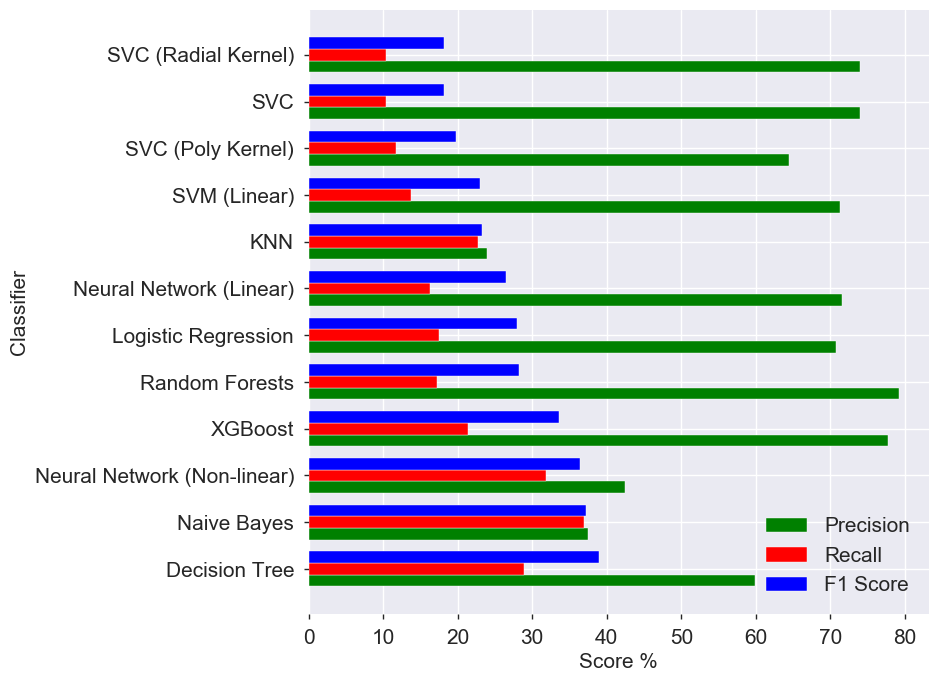

In [263]:
fig = plt.figure(figsize=[8,8], dpi=100)

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = class_metric_df['Precision'].values
bars2 = class_metric_df['Recall'].values
bars3 = class_metric_df['F1 Score'].values
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.barh(r1, bars1, color='g', height=barWidth, edgecolor='white', label='Precision')
plt.barh(r2, bars2, color='r', height=barWidth, edgecolor='white', label='Recall')
plt.barh(r3, bars3, color='b', height=barWidth, edgecolor='white', label='F1 Score')
 
# Add xticks on the middle of the group bars
plt.xticks(fontsize=15)
plt.xlabel('Score %', fontsize=15)
plt.yticks([r + barWidth for r in range(len(bars1))], class_metric_df.index, fontsize=15)
plt.ylabel('Classifier', fontsize=15)
 
# Create legend & Show graphic
plt.legend(fontsize=15)
plt.show()

In [268]:
classifiers = [    \
    KNeighborsClassifier(n_neighbors=1),    \
    LogisticRegression(C = 0.12),    \
    GaussianNB(),    \
    SVC(gamma="auto", probability=True),    \
    SVC(kernel="poly", gamma="auto", probability=True),    \
    SVC(gamma="scale", probability=True),    \
    DecisionTreeClassifier(max_depth=4),    \
    RandomForestClassifier(n_estimators=100),    \
    MLPClassifier(activation="identity"),    \
    MLPClassifier(),    \
    XGBClassifier()]

model_list = ['KNN', 'Logistic Regression', 'Naive Bayes',    \
              'SVC', 'SVC (Poly Kernel)', 'SVC (Radial Kernel)',    \
              'Decision Tree', 'Random Forests', 'Neural Network (Linear)',    \
              'Neural Network (Non-linear)',    \
              'XGBoost']
precision_list = []
recall_list = []
f1_score_list = []
model_curve_dict = {}

for index, classifier in enumerate(classifiers):
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_tr, y_train)  
    print(classifier)
    y_predict = pipe.predict(X_v)
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, classifier.predict_proba(X_v)[:,1] )
    model_curve_dict[model_list[index]] = pd.DataFrame(list(zip(precision_curve, recall_curve, threshold_curve)),
            columns=['precision','recall', 'threshhold'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.12, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
GaussianNB(priors=None, var_smoothing=1e-09)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, ra

/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [269]:
classifiers = [    \
    KNeighborsClassifier(n_neighbors=1),    \
    LogisticRegression(C = 0.12),    \
    GaussianNB(),    \
    SVC(gamma="auto", probability=True),    \
    SVC(kernel="poly", gamma="auto", probability=True),    \
    SVC(gamma="scale", probability=True),    \
    DecisionTreeClassifier(max_depth=4),    \
    RandomForestClassifier(n_estimators=100),    \
    MLPClassifier(activation="identity"),    \
    MLPClassifier(),    \
    XGBClassifier()]

model_list = ['KNN', 'Logistic Regression', 'Naive Bayes',    \
              'SVC', 'SVC (Poly Kernel)', 'SVC (Radial Kernel)',    \
              'Decision Tree', 'Random Forests', 'Neural Network (Linear)',    \
              'Neural Network (Non-linear)',    \
              'XGBoost']
roc_curve_dict = {}

for index, classifier in enumerate(classifiers):
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_tr, y_train)  
    print(classifier)
    fpr, tpr, thresholds = roc_curve(y_val, classifier.predict_proba(X_v)[:,1])
    roc_curve_dict[model_list[index]] = pd.DataFrame(list(zip(fpr, tpr, thresholds)),    \
                                                     columns=['False Positive Rate','True Positive Rate', 'Threshhold'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.12, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
GaussianNB(priors=None, var_smoothing=1e-09)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, ra

/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [348]:
# with open('roc_curve_dict.pkl', 'wb') as to_write:
#     pickle.dump(roc_curve_dict, to_write)

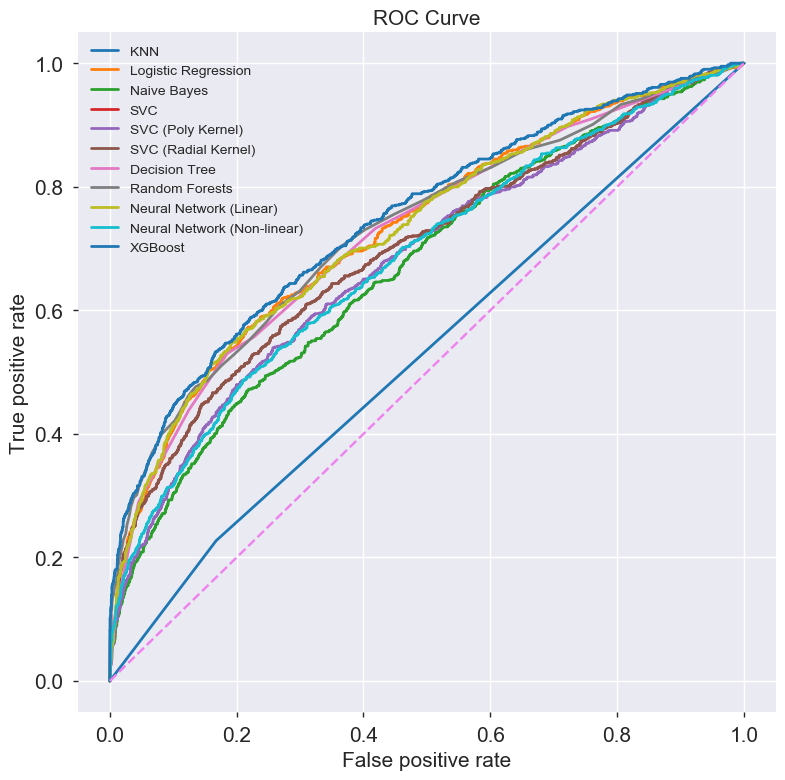

In [270]:
fig = plt.figure(figsize=[9,9], dpi=100)

plt.plot(roc_curve_dict['KNN']['False Positive Rate'].values, roc_curve_dict['KNN']['True Positive Rate'].values,lw=2, label='KNN')
plt.plot(roc_curve_dict['Logistic Regression']['False Positive Rate'].values, roc_curve_dict['Logistic Regression']['True Positive Rate'].values,lw=2, label='Logistic Regression')
plt.plot(roc_curve_dict['Naive Bayes']['False Positive Rate'].values, roc_curve_dict['Naive Bayes']['True Positive Rate'].values,lw=2, label='Naive Bayes')
plt.plot(roc_curve_dict['SVC']['False Positive Rate'].values, roc_curve_dict['SVC']['True Positive Rate'].values,lw=2, label='SVC')
plt.plot(roc_curve_dict['SVC (Poly Kernel)']['False Positive Rate'].values, roc_curve_dict['SVC (Poly Kernel)']['True Positive Rate'].values,lw=2, label='SVC (Poly Kernel)')
plt.plot(roc_curve_dict['SVC (Radial Kernel)']['False Positive Rate'].values, roc_curve_dict['SVC (Radial Kernel)']['True Positive Rate'].values,lw=2, label='SVC (Radial Kernel)')
plt.plot(roc_curve_dict['Decision Tree']['False Positive Rate'].values, roc_curve_dict['Decision Tree']['True Positive Rate'].values,lw=2, label='Decision Tree')
plt.plot(roc_curve_dict['Random Forests']['False Positive Rate'].values, roc_curve_dict['Random Forests']['True Positive Rate'].values,lw=2, label='Random Forests')
plt.plot(roc_curve_dict['Neural Network (Linear)']['False Positive Rate'].values, roc_curve_dict['Neural Network (Linear)']['True Positive Rate'].values,lw=2, label='Neural Network (Linear)')
plt.plot(roc_curve_dict['Neural Network (Non-linear)']['False Positive Rate'].values, roc_curve_dict['Neural Network (Non-linear)']['True Positive Rate'].values,lw=2, label='Neural Network (Non-linear)')
plt.plot(roc_curve_dict['XGBoost']['False Positive Rate'].values, roc_curve_dict['XGBoost']['True Positive Rate'].values,lw=2, label='XGBoost')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ROC Curve', fontsize=15);
plt.legend(fontsize=10)

In [198]:
roc_curve_dict['KNN']['False Positive Rate']

0    0.000000
1    0.167614
2    1.000000
Name: False Positive Rate, dtype: float64

GridSearch on top 3 models
Oversampling
Transforming Features
    - KNN
    - Logistic Regression
        - Watch out for multicollinearity

## Cross-Validation and Upsampling through imblearn



In [278]:
kf = KFold(n_splits=5, random_state=42, shuffle=False)

In [320]:
# Scale training and test dataframes:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

std = StandardScaler()
std.fit(X_train_cv.values)

X_tr_cv_scaled = std.transform(X_train_cv.values)
# X_val_scaled = std.transform(X_val.values)
X_te_cv_scaled = std.transform(X_test_cv.values)

# Convert arrays back to dataframes - dropped outliers, no dropped p-vals
X_tr_cv = pd.DataFrame(X_tr_cv_scaled, index = X_train_cv.index, columns = X_columns)
# X_v = pd.DataFrame(X_val_scaled, index = X_val.index, columns = X_columns)
X_te_cv = pd.DataFrame(X_te_cv_scaled, index = X_test_cv.index, columns = X_columns)

In [ ]:
cv_results = defaultdict(list)

In [281]:
classifiers = [    \
    KNeighborsClassifier(n_neighbors=1),    \
    LogisticRegression(C = 0.12, solver='lbfgs'),    \
    GaussianNB(),    \
    LinearSVC(),    \
    SVC(gamma="auto"),    \
    SVC(kernel="poly", gamma="auto"),    \
    SVC(gamma="scale"),    \
    DecisionTreeClassifier(max_depth=4),    \
    RandomForestClassifier(n_estimators=100),    \
    MLPClassifier(activation="identity"),    \
    MLPClassifier(),    \
    XGBClassifier()]

model_list = ['KNN', 'Logistic Regression', 'Naive Bayes',    \
              'SVM (Linear)', 'SVC', 'SVC (Poly Kernel)', 'SVC (Radial Kernel)',    \
              'Decision Tree', 'Random Forests', 'Neural Network (Linear)',    \
              'Neural Network (Non-linear)',    \
              'XGBoost']

precision_list = []
recall_list = []
f1_score_list = []

for index, classifier in enumerate(classifiers):
    pipe = Pipeline(steps=[('classifier', classifier)])
    imba_pipeline = make_pipeline(SMOTE(random_state=42), classifier)  
    print(classifier)
    precision_list.append(100*cross_val_score(imba_pipeline, X_tr_cv, y_train_cv, scoring='precision', cv=kf))
    recall_list.append(100*cross_val_score(imba_pipeline, X_tr_cv, y_train_cv, scoring='recall', cv=kf))
#    f1_score_list.append(100*cross_val_score(imba_pipeline, X_train, y_train, scoring='recall', cv=kf))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
LogisticRegression(C=0.12, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/skl

GaussianNB(priors=None, var_smoothing=1e-09)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_wei

/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45'] ['Debut_Position', 'Song_Name_Count', 'Performer_Count', 'Danceability', 'Energy', 'Loudness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_min', 'Debut_Season(T.Spring)', 'Debut_Season(T.Summer)', 'Debut_Season(T.Winter)', 'Debut_Month(T.August)', 'Debut_Month(T.December)', 'Debut_Month(T.February)', 'Debut_Month(T.January)', 'Debut_Month(T.July)', 'Debut_Month(T.June)', 'Debut_Month(T.March)', 'Debut_Month(T.May)', 'Debut_Month(T.November)', 'Debut_Month(T.October)', 'Debut_Month(T.September)', "Debut_Decade(T.10's)", "Debut_Decade(T.50's)", "Debut_Decade(T.60's)", "Debut_Decade(T.70's)", "Debut_Decade(T.80's)", "Debut_Decade(T.90's)", 'Key(T.B)', 'Key(T.Bb)', 'Key(T.C)', 'Key(T.C#)', 'Key(T.D)', 'Key(T.D#)', 'Key(T.E)', 'Key(T.F)', 'Key(T.F#)', 'Key(T.G)', 'Key(T.G#)', 'Mode(T.Minor)', 'Time_Signature(T.4/4)', 'Time_Signature(T.5/4)']
expected f43, f42, f40, f22, f8, f13, f2, f3, f19, f26, f5, f29, f28, f20, f30, f37, f12, f21, f27, f36, f4, f9, f45, f15, f17, f16, f0, f24, f38, f35, f7, f23, f14, f31, f39, f25, f18, f1, f41, f11, f10, f6, f32, f33, f34, f44 in input data
training data did not have the following fields: Key(T.C#), Debut_Month(T.October), Debut_Month(T.March), Loudness, Key(T.F), Tempo, Duration_min, Debut_Position, Song_Name_Count, Key(T.G), Mode(T.Minor), Debut_Season(T.Spring), Debut_Month(T.May), Key(T.E), Debut_Month(T.July), Debut_Decade(T.70's), Debut_Season(T.Winter), Debut_Decade(T.60's), Debut_Month(T.January), Liveness, Key(T.D#), Key(T.F#), Time_Signature(T.5/4), Debut_Decade(T.50's), Key(T.B), Debut_Decade(T.10's), Energy, Key(T.Bb), Debut_Month(T.September), Debut_Month(T.December), Debut_Decade(T.80's), Performer_Count, Debut_Month(T.August), Valence, Acousticness, Key(T.G#), Time_Signature(T.4/4), Key(T.D), Debut_Season(T.Summer), Debut_Month(T.November), Instrumentalness, Debut_Month(T.June), Debut_Month(T.February), Danceability, Debut_Decade(T.90's), Key(T.C)

In [282]:
len(precision_list)

11

In [288]:
precision_list[0].mean()

24.76390928274598

In [284]:
recall_list

[array([28.19237148, 35.1910828 , 33.33333333, 33.60258481, 28.83031301]),
 array([61.52570481, 64.17197452, 65.63573883, 65.75121163, 66.06260297]),
 array([68.15920398, 66.71974522, 67.6975945 , 62.84329564, 65.07413509]),
 array([60.86235489, 64.64968153, 65.29209622, 65.91276252, 65.89785832]),
 array([45.93698176, 45.38216561, 45.87628866, 47.01130856, 46.45799012]),
 array([47.92703151, 52.07006369, 49.48453608, 53.63489499, 51.89456343]),
 array([45.6053068 , 45.22292994, 45.01718213, 46.5266559 , 46.62273476]),
 array([63.01824212, 51.75159236, 48.62542955, 65.26655897, 64.90939044]),
 array([33.83084577, 35.35031847, 31.44329897, 33.27948304, 30.97199341]),
 array([61.19402985, 66.08280255, 65.97938144, 64.94345719, 65.56836903]),
 array([35.15754561, 40.92356688, 30.41237113, 37.9644588 , 39.04448105])]

In [291]:
precision_avg_list = []
recall_avg_list = []

for p in precision_list:
    precision_avg_list.append(p.mean())
for r in recall_list:
    recall_avg_list.append(r.mean())
        

In [306]:
metric_dict = {'Precision': precision_avg_list, 'Recall': recall_avg_list}

f1_score_list = []

for i in range(0,11):
    f1_score_list.append(2*metric_dict['Precision'][i]*metric_dict['Recall'][i]/    \
                         (metric_dict['Precision'][i] + metric_dict['Recall'][i]))

In [307]:
metric_dict['F1 Score'] = f1_score_list

In [312]:
metric_df = pd.DataFrame(metric_dict, index = model_list[:-1])
metric_df.sort_values(by='F1 Score', ascending = False, inplace=True)
metric_df.round(1)

Precision  Recall  F1 Score
Logistic Regression               31.9    64.6      42.7
SVM (Linear)                      31.7    64.5      42.5
Decision Tree                     33.3    58.7      42.5
Neural Network (Linear)           31.1    64.8      42.1
SVC (Radial Kernel)               35.5    45.8      40.0
SVC                               35.2    46.1      39.9
SVC (Poly Kernel)                 31.6    51.0      39.0
Random Forests                    47.5    33.0      38.9
Naive Bayes                       23.7    66.1      34.9
Neural Network (Non-linear)       32.6    36.7      34.6
KNN                               24.8    31.8      27.9

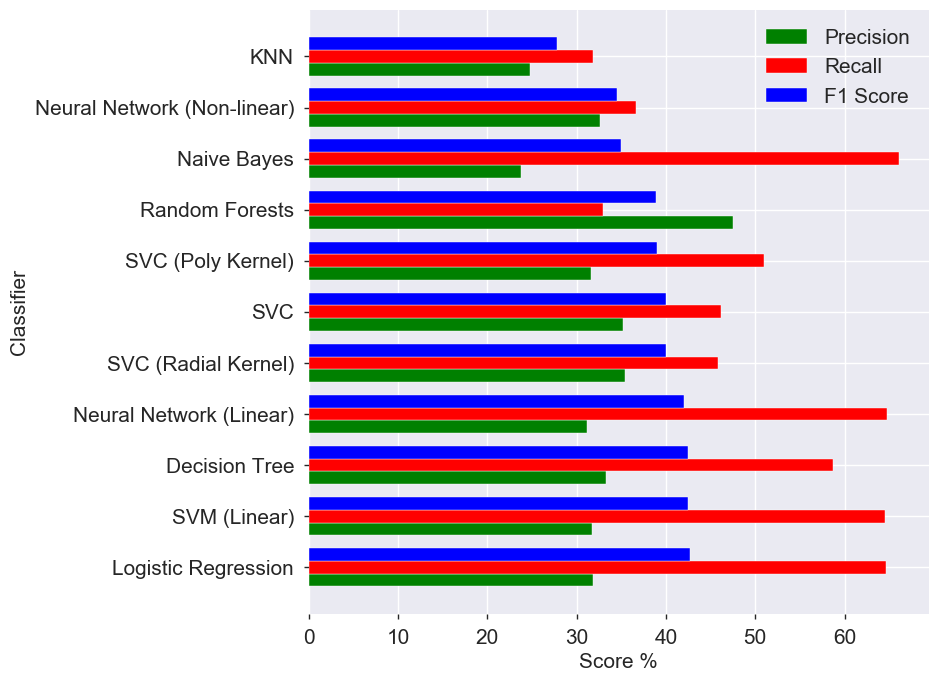

In [314]:
fig = plt.figure(figsize=[8,8], dpi=100)

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = metric_df['Precision'].values
bars2 = metric_df['Recall'].values
bars3 = metric_df['F1 Score'].values
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.barh(r1, bars1, color='g', height=barWidth, edgecolor='white', label='Precision')
plt.barh(r2, bars2, color='r', height=barWidth, edgecolor='white', label='Recall')
plt.barh(r3, bars3, color='b', height=barWidth, edgecolor='white', label='F1 Score')
 
# Add xticks on the middle of the group bars
plt.xticks(fontsize=15)
plt.xlabel('Score %', fontsize=15)
plt.yticks([r + barWidth for r in range(len(bars1))], metric_df.index, fontsize=15)
plt.ylabel('Classifier', fontsize=15)
 
# Create legend & Show graphic
plt.legend(fontsize=15)
plt.show()

## ADASYN

- All models improve except Random Forests and Decision Trees

In [335]:
classifiers = [    \
#    KNeighborsClassifier(n_neighbors=1),    \
    LogisticRegression(C = 0.12, solver='lbfgs'),    \
    GaussianNB(),    \
    LinearSVC(),    \
#    SVC(gamma="auto"),    \
#    SVC(kernel="poly", gamma="auto"),    \
#    SVC(gamma="scale"),    \
    DecisionTreeClassifier(max_depth=4),    \
    RandomForestClassifier(n_estimators=100),    \
    MLPClassifier(activation="identity")]
#    MLPClassifier(),    \
#    XGBClassifier()]

# model_list = ['KNN', 'Logistic Regression', 'Naive Bayes',    \
#               'SVM (Linear)', 'SVC', 'SVC (Poly Kernel)', 'SVC (Radial Kernel)',    \
#               'Decision Tree', 'Random Forests', 'Neural Network (Linear)',    \
#               'Neural Network (Non-linear)',    \
#               'XGBoost']
               
model_list2 = ['Logistic Regression', 'Naive Bayes', 'SVM (Linear)', 'Decision Tree',    \
              'Random Forests', 'Neural Network (Linear)']
#               'XGBoost']

precision_list = []
recall_list = []
f1_score_list = []

for index, classifier in enumerate(classifiers):
    pipe = Pipeline(steps=[('classifier', classifier)])
    imba_pipeline = make_pipeline(ADASYN(random_state=42), classifier)  
    print(classifier)
    precision_list.append(100*cross_val_score(imba_pipeline, X_tr_cv, y_train_cv, scoring='precision', cv=kf))
    recall_list.append(100*cross_val_score(imba_pipeline, X_tr_cv, y_train_cv, scoring='recall', cv=kf))
#    f1_score_list.append(100*cross_val_score(imba_pipeline, X_train, y_train, scoring='recall', cv=kf))


LogisticRegression(C=0.12, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
GaussianNB(priors=None, var_smoothing=1e-09)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/andrewgraves/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.99

6

In [336]:
precision_avg_list = []
recall_avg_list = []

for p in precision_list:
    precision_avg_list.append(p.mean())
for r in recall_list:
    recall_avg_list.append(r.mean())
    
metric_dict = {'Precision': precision_avg_list, 'Recall': recall_avg_list}

In [342]:
f1_score_list = []

for i in range(0,6):
    f1_score_list.append(2*metric_dict['Precision'][i]*metric_dict['Recall'][i]/    \
                         (metric_dict['Precision'][i] + metric_dict['Recall'][i]))

metric_dict = {'Precision': precision_avg_list, 'Recall': recall_avg_list}

f1_score_list = []

for i in range(0,6):
    f1_score_list.append(2*metric_dict['Precision'][i]*metric_dict['Recall'][i]/    \
                         (metric_dict['Precision'][i] + metric_dict['Recall'][i]))

metric_dict['F1 Score'] = f1_score_list

In [345]:
metric_df = pd.DataFrame(metric_dict, index = model_list2)
metric_df.sort_values(by='F1 Score', ascending = False, inplace=True)
metric_df.round(1)

Precision  Recall  F1 Score
Neural Network (Linear)       32.9    65.1      43.8
SVM (Linear)                  32.9    65.0      43.7
Logistic Regression           32.9    64.7      43.6
Decision Tree                 32.8    59.1      42.2
Random Forests                46.9    33.0      38.7
Naive Bayes                   23.8    70.1      35.6

In [349]:
# with open('metric_df.pkl', 'wb') as to_write:
#     pickle.dump(metric_df, to_write)

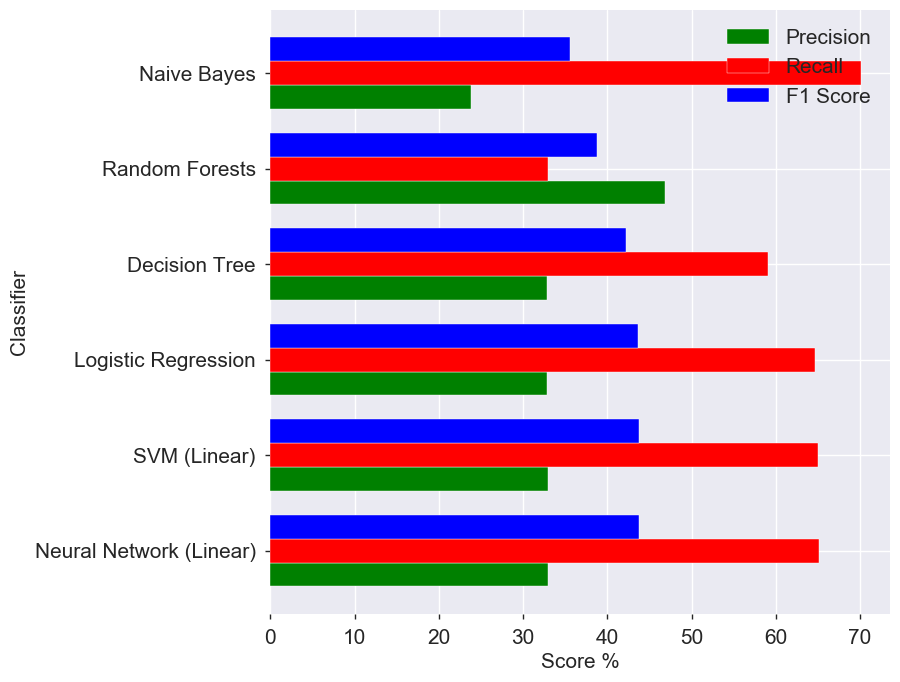

In [346]:
fig = plt.figure(figsize=[8,8], dpi=100)

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = metric_df['Precision'].values
bars2 = metric_df['Recall'].values
bars3 = metric_df['F1 Score'].values
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.barh(r1, bars1, color='g', height=barWidth, edgecolor='white', label='Precision')
plt.barh(r2, bars2, color='r', height=barWidth, edgecolor='white', label='Recall')
plt.barh(r3, bars3, color='b', height=barWidth, edgecolor='white', label='F1 Score')
 
# Add xticks on the middle of the group bars
plt.xticks(fontsize=15)
plt.xlabel('Score %', fontsize=15)
plt.yticks([r + barWidth for r in range(len(bars1))], metric_df.index, fontsize=15)
plt.ylabel('Classifier', fontsize=15)
 
# Create legend & Show graphic
plt.legend(fontsize=15)
plt.show()